In [47]:
import glob
from bs4 import BeautifulSoup
from typing import Dict, Iterator, List
from pathlib import Path
import json
import pandas as pd
import prompt_utils as p
import unidecode
from tqdm.auto import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split
import numpy as np 
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings("ignore")

BASE_DIR = Path('..') / 'data' / 'bulk_downloads'
OUTPUT_DIR_NAME = 'downloaded_content'

BASE_DIR = BASE_DIR.resolve()
print(f'Using base directory: {BASE_DIR}')


def iter_chunks(df: pd.DataFrame, chunk_size: int = 2):
    """Yield consecutive chunks of `chunk_size` rows from the DataFrame."""
    for start in range(0, len(df), chunk_size):
        yield df.iloc[start:start + chunk_size]

def proc(l):
    s = pd.Series(l)
    s = s.str.replace('"', '')
    s = s.apply(lambda x:  x if x in ['yes', 'no'] else 'no')
    return s

def train_tfidf_logreg(texts, labels, min_df=.1, max_df=.9):
    """
    Fit a TF–IDF + logistic regression model on `texts` (list/Series of str) and `labels`.
    Returns the trained pipeline; call `.predict`/`.predict_proba` on new text.
    """
    model = make_pipeline(
        TfidfVectorizer(ngram_range=(1, 2), min_df=min_df, max_df=max_df, stop_words='english'),
        LogisticRegression(max_iter=1000)
    )
    model.fit(texts, labels)
    return model

def top_tfidf_features(model, class_id, top_k=10, bottom_k=0):
    vec = model.named_steps['tfidfvectorizer']
    clf = model.named_steps['logisticregression']
    feature_names = np.array(vec.get_feature_names_out())
    classes = list(clf.classes_)
    if isinstance(class_id, str):
        if class_id not in classes:
            raise ValueError(f"class '{class_id}' not in {classes}")
        class_idx = classes.index(class_id)
    else:
        class_idx = class_id
    coefs = clf.coef_
    if coefs.shape[0] == 1:
        weights = coefs[0]
        if class_idx == 0:
            weights = -weights  # flip for negative class
    else:
        weights = coefs[class_idx]
    top = []
    bottom = []
    if top_k > 0:
        top_ids = np.argsort(weights)[-top_k:][::-1]
        top = list(zip(feature_names[top_ids], weights[top_ids]))
    if bottom_k > 0:
        bottom_ids = np.argsort(weights)[:bottom_k]
        bottom = list(zip(feature_names[bottom_ids], weights[bottom_ids]))
    return {"top": top, "bottom": bottom}
    

def downsample_to_class_balance(df: pd.DataFrame, label_col: str, random_state: int | None = None) -> pd.DataFrame:
    """
    Return a new DataFrame with an equal number of rows per class from `label_col`.
    The class size is capped at the smallest class count; sampling is without replacement.
    """
    counts = df[label_col].value_counts(dropna=False)
    target = counts.min()
    balanced_parts = []
    for label, group in df.groupby(label_col):
        if len(group) > target:
            group = group.sample(target, random_state=random_state)
        balanced_parts.append(group)
    return pd.concat(balanced_parts, ignore_index=True)

def iter_documents(base_dir: Path = BASE_DIR, output_dir_name: str = OUTPUT_DIR_NAME) -> Iterator[dict]:
    for agency_dir in sorted(base_dir.iterdir()):
        dl_root = agency_dir / output_dir_name
        if not dl_root.exists():
            continue
        for csv_dir in sorted(dl_root.iterdir()):
            if not csv_dir.is_dir():
                continue
            for doc_dir in sorted(csv_dir.iterdir()):
                metadata_path = doc_dir / 'metadata.json'
                metadata: Dict[str, str] = {}
                if metadata_path.exists():
                    metadata = json.loads(metadata_path.read_text(encoding='utf-8'))
                yield {
                    'agency': agency_dir.name,
                    'csv_name': csv_dir.name,
                    'doc_id': doc_dir.name,
                    'metadata': metadata,
                    'doc_path': doc_dir,
                }

def process_text_from_df(df):
    return (
        df
        .apply(lambda x: x['html'] if pd.notnull(x['html']) else x['text'], axis=1)
        .apply(lambda x: BeautifulSoup(x).get_text(' ') if pd.notnull(x) else None)
    )

total_docs = 0
preview: List[dict] = []
for entry in iter_documents():
    total_docs += 1
    if len(preview) < 25:
        preview.append(entry)

print(f'Found {total_docs} documents with downloaded payloads.')

Using base directory: /Users/spangher/Projects/stanford-research/rfi-research/regulations-demo/data/bulk_downloads
Found 33779 documents with downloaded payloads.


In [48]:
summary_rows = []
for entry in iter_documents():
    text_files = sorted(entry['doc_path'].glob('*.txt'))
    text = text_files[0].read_text(encoding='utf-8') if text_files else None 
    html_files = sorted(entry['doc_path'].glob('*.htm*'))
    html = html_files[0].read_text(encoding='utf-8', errors='replace') if html_files else None
    if (text is None) and (html is None) and not entry['doc_path'].is_dir():
        continue
    row = {
        'agency': entry['agency'],
        'csv_name': entry['csv_name'],
        'doc_id': entry['doc_id'],
        'docket_id': entry["metadata"].get("Docket ID"),
        'title': entry['metadata'].get('Title') or entry['metadata'].get('title'),
        'posted_date': entry['metadata'].get('Posted Date') or entry['metadata'].get('postedDate'),
        'text': text,
        'html': html,
        'files': ', '.join(sorted(p.name for p in entry['doc_path'].iterdir())),
    }
    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows)

In [3]:
(summary_df[['agency', 'csv_name']]
 .assign(csv_name=lambda df: df['csv_name'].apply(lambda x: {'rule': 'rules', 'proposed_rule': 'proposed_rules'}.get(x,x)))
 .value_counts()
 .unstack().fillna(0).astype(int).loc[['epa_2020_2021', 'doe_2023', 'nist_2023', 'sec_2023']]
)

csv_name,notice,proposed_rules,public_submission,rules,supporting_material
agency,,,,,
epa_2020_2021,1053,839,7734,541,21106
doe_2023,261,12,421,8,9
nist_2023,6,2,90,0,0
sec_2023,1642,25,0,28,0


In [5]:
summary_df['csv_name'].value_counts()

csv_name
supporting_material    21115
public_submission       8245
notice                  2962
proposed_rules           839
rules                    541
proposed_rule             39
rule                      36
Name: count, dtype: int64

In [6]:
summary_df['text'] = summary_df['text'].progress_apply(lambda x: unidecode.unidecode(x) if pd.notnull(x) else x)

  0%|          | 0/33777 [00:00<?, ?it/s]

In [49]:
EPA_TO_SAMPLE = 10
SEC_TO_SAMPLE = 500
DOE_TO_SAMPLE = 51

sample_to_annotate = (
    summary_df
         .loc[lambda df: df['csv_name'].isin(['supporting_material', 'rules', 'rule', 'notice'])]
         .loc[lambda df: df['agency'].isin(['doe_2023', 'epa_2020_2021', 'sec_2023'])]
         .assign(csv_name=lambda df: df['csv_name'].apply(lambda x: {'rule': 'rules'}.get(x, x)))
         # .pipe(lambda df: downsample_to_class_balance(df, label_col='agency'))
         .pipe(lambda df: downsample_to_class_balance(df, label_col='csv_name'))
         .pipe(lambda df: pd.concat([
             df.loc[lambda df: df['agency'] == 'epa_2020_2021'].sample(EPA_TO_SAMPLE),
             df.loc[lambda df: df['agency'] == 'sec_2023'],#.sample(SEC_TO_SAMPLE),
             df.loc[lambda df: df['agency'] == 'doe_2023']#.sample(DOE_TO_SAMPLE),
         ]))
)#.shape

train_df, test_df = train_test_split(sample_to_annotate, test_size=.1)
sample_to_annotate = pd.concat([train_df.assign(split='train'), test_df.assign(split='test')])

In [50]:
sample_to_annotate['agency'].value_counts()

agency
sec_2023         342
doe_2023          58
epa_2020_2021     10
Name: count, dtype: int64

In [51]:
sample_to_annotate['csv_name'].value_counts()

csv_name
notice                 365
rules                   42
supporting_material      3
Name: count, dtype: int64

In [52]:
IDENTIFICATION_PROMPT = """You are a helpful legal assistant. 
Please tell me if this text CONTAINS government responses to comments submitted. Do NOT identify texts 
that simply mention comment-gathering process. The text must specifically AND directly respond directly to user comments.
Answer with just "yes" or "no":

<text>
{input_text}
</text>

Your response:
"""

In [61]:
r = p.process_one(
    t, 
    prompt_template=IDENTIFICATION_PROMPT, 
    model='gpt-5-mini', 
)

In [62]:
r

'yes'

In [53]:
sample_to_annotate['parsed_text'] = sample_to_annotate.pipe(process_text_from_df)
# summ_df_w_comments['parsed_text'] = summ_df_w_comments.pipe(process_text_from_df)

In [54]:
files = summary_df['html'].tolist()

In [55]:
import prompt_utils as p

In [56]:
all_responses = await p.process_batch(
    sample_to_annotate['text'], 
    prompt_template=IDENTIFICATION_PROMPT, 
    model='gpt-5-mini', 
    concurrency=100
)

  0%|          | 0/410 [00:00<?, ?it/s]

In [57]:
sample_to_annotate['label'] = all_responses
sample_to_annotate['label'] = sample_to_annotate['label'].apply(lambda x: 'no' if x not in ['yes', 'no'] else x)

In [58]:
sample_to_annotate.value_counts(['agency', 'label']).unstack()

label,no,yes
agency,,
doe_2023,55.0,3.0
epa_2020_2021,4.0,6.0
sec_2023,342.0,NaN


In [465]:
import re 
AGENCY_STOPWORDS = {"epa", "doe", "nist", "sec"}
def normalize_text(text: str, stopwords=AGENCY_STOPWORDS) -> str:
    """
    Replace all numbers with '<number>' and drop stopwords such as 'epa'.
    """
    if not text:
        return ""
    # 1. replace any sequence of digits (optionally with punctuation) with <number>
    text = re.sub(r"\d+(?:[\d,.\-]*\d+)?", "<number>", text.lower())
    # 2. remove stopwords
    tokens = [tok for tok in re.findall(r"\b\w+\b", text) if tok not in stopwords]
    return " ".join(tokens)

In [466]:
sample_to_annotate['normalized_text'] = sample_to_annotate['parsed_text'].progress_apply(normalize_text)

  0%|          | 0/653 [00:00<?, ?it/s]

In [467]:
clf = train_tfidf_logreg(
    sample_to_annotate.loc[lambda df: df['split'] == 'train']['normalized_text'].fillna(''), 
    sample_to_annotate.loc[lambda df: df['split'] == 'train']['label'],
    min_df=.05, max_df=.5
)

In [468]:
y_true = sample_to_annotate.loc[lambda df: df['split'] == 'test']['label']
y_proba = pd.Series(clf.predict_proba(sample_to_annotate.loc[lambda df: df['split'] == 'test']['normalized_text'].fillna(''))[:, 1])

In [469]:
roc_auc_score(y_true == 'yes', y_proba)

0.788675429726997

In [470]:
top_tfidf_features(clf, 'yes', top_k=20, bottom_k=10)

{'top': [('commenter', 2.3679245091238137),
  ('commenters', 1.4778274244135945),
  ('pm', 1.0077241927338134),
  ('executive order', 0.9678015552817164),
  ('executive', 0.9495593930295883),
  ('caa', 0.8657846428579951),
  ('monitoring', 0.8497579290768064),
  ('emissions', 0.8010268469059905),
  ('comment number', 0.7895732409227536),
  ('partial', 0.7684380549573069),
  ('yes', 0.7646359997349261),
  ('order number', 0.7581492475464535),
  ('proposed rule', 0.7510842474171997),
  ('revisions', 0.7459345661468222),
  ('ppm', 0.7425392607030521),
  ('npl', 0.7266206190264906),
  ('number ppm', 0.718540082274816),
  ('source', 0.713249222958959),
  ('changes', 0.709051487285852),
  ('sites', 0.7016346043665461)],
 'bottom': [('georgia', -0.9704644061507613),
  ('shall', -0.6450150944942117),
  ('energy', -0.5548497150145747),
  ('negative', -0.5205039024993776),
  ('registration review', -0.5144556789933469),
  ('case number', -0.5094114989462042),
  ('department energy', -0.469856543

In [471]:
summary_df['processed_text'] = summary_df.pipe(process_text_from_df)
summary_df['normalized_text'] = summary_df['processed_text'].progress_apply(normalize_text)

  0%|          | 0/33777 [00:00<?, ?it/s]

In [472]:
o = [] 
for c in tqdm(iter_chunks(summary_df['normalized_text'].fillna(''), chunk_size=50), total=int(len(summary_df)/50)):
    o.extend(clf.predict(c))

  0%|          | 0/675 [00:00<?, ?it/s]

In [473]:
summary_df['pred_response'] = o

In [474]:
summary_df['pred_response'].value_counts()

pred_response
no     32252
yes     1525
Name: count, dtype: int64

In [475]:
summary_df.loc[lambda df: df['pred_response'] == 'yes']['agency'].value_counts()

agency
epa_2020_2021    1524
doe_2023            1
Name: count, dtype: int64

In [40]:
import os
from typing import Dict, Iterable, List, Optional
BASE_DIR = Path("../data/bulk_downloads").resolve()
def _public_submission_paths(base_dir: Path = BASE_DIR) -> Iterable[Path]:
    """Yield every …/public_submission.csv under data/bulk_downloads."""
    return base_dir.glob("*/public_submission.csv")

def load_public_submissions(base_dir: Path = BASE_DIR) -> pd.DataFrame:
    """
    Read every …/public_submission.csv, annotate rows with their download folder,
    local files, and saved metadata (if present), and return one concatenated DataFrame.
    """
    frames: List[pd.DataFrame] = []
    for csv_path in tqdm(base_dir.glob("*/public_submission.csv"), desc="Loading..."):
        if os.path.getsize(csv_path) == 0:
            continue
        df = pd.read_csv(csv_path, dtype=str, keep_default_na=False)
        df["source_dir"] = str(csv_path.parent.resolve())
        df["csv_name"] = csv_path.stem  # 'public_submission'
        #
        document_dirs: List[Optional[Path]] = []
        local_files: List[List[Path]] = []
        local_files_content: List[List[str]] = []
        metadata_blobs: List[Optional[Dict[str, str]]] = []
        #
        for _, row in df.iterrows():
            doc_id = row.get("Document_ID") or row.get("Document ID")
            if not doc_id:
                document_dirs.append(None)
                local_files.append([])
                metadata_blobs.append(None)
                continue
      
            doc_dir = Path(row.source_dir) / "downloaded_content" / row.csv_name / doc_id
            if doc_dir.exists():
                document_dirs.append(doc_dir)
                files = sorted(p for p in doc_dir.iterdir() if p.is_file())
                txt_files = list(filter(lambda x: x.suffix == '.txt', files))
                txt_file_content = list(map(lambda x: unidecode.unidecode(x.read_text(encoding='utf-8-sig', errors='replace')), txt_files))
                local_files.append(files)
                local_files_content.append(txt_file_content)
                metadata_path = doc_dir / "metadata.json"
                metadata = (
                    json.loads(metadata_path.read_text(encoding="utf-8"))
                    if metadata_path.exists()
                    else None
                )
                metadata_blobs.append(metadata)
            else:
                document_dirs.append(None)
                local_files.append([])
                local_files_content.append([])
                metadata_blobs.append(None)
                
        df["document_dir"] = document_dirs
        df["local_files"] = local_files
        df["local_file_content"] = local_files_content
        df["metadata_json"] = metadata_blobs
        frames.append(df)
        
    if not frames:
        raise FileNotFoundError("No public_submission.csv files found under data/bulk_downloads.")
    return pd.concat(frames, ignore_index=True)

In [41]:
comments_df = load_public_submissions()
comments_df['text'] = comments_df['Comment'] + '\n' + comments_df['local_file_content'].str.join('\n')

Loading...: 0it [00:00, ?it/s]

In [ ]:
summ_df_w_comments = summary_df.loc[lambda df: df['docket_id'].isin(comments_df['Docket ID'])]

In [480]:
summ_df_w_comments['pred_response'].value_counts()

pred_response
no     24413
yes     1200
Name: count, dtype: int64

In [481]:
# df = pd.concat([proc(all_responses_1), proc(all_responses_2), proc(all_responses_3)], axis=1)
# vals = df.apply(lambda x: pd.Series(Counter(x)).sort_values(ascending=False).index[0], axis=1)
# summ_df_w_comments['responses'] = vals.tolist()
# summ_df_w_comments['processed_text'] = summ_df_w_comments.pipe(process_text_from_df)
# summ_df_w_comments['processed_text'] = summ_df_w_comments['processed_text'].progress_apply(lambda x: unidecode.unidecode(x) if pd.notnull(x) else x)
# # summ_df_w_comments.drop(columns=['text', 'html', 'parsed_text']).to_csv('2025-11-15__summ-df-training-data-1.csv')

In [482]:
PULL_CHUNKS_PROMPT = """You are a helpful legal assistant. I will show you a government document.
It contains responses to comments submitted by members of the public.

Your task is to identify passages where the agency is directly responding to comments.
I expect there may be multiple such passages, each referring to a specific comment or a group of comments.

You should:
- Find text where the document clearly describes what commenters said
  (e.g., “Several commenters argued that…”, “One commenter stated that…”).
- For each such description, find the corresponding text where the agency responds
  to that position (often in the same paragraph or immediately following).
- Ignore text that only mentions the comment-gathering process in general
  (e.g., “The agency received 300 comments”) if it does not substantively describe
  comment content and an agency response.

For each identified comment→response pair, extract and annotate it.

Respond in the following JSON format (a list of objects):

[
  {{
    "content_of_comment": "<exact text from the document that describes the commenter(s)’ position>",
    "response_to_comment": "<exact text from the document that gives the agency’s response to that position>",
    "summarized_content_of_comment": "<short summary of what the comment is about>",
    "summarized_response_to_comment": "<short summary of how the agency responds>",

    "quoted_or_paraphrased": "quoted | paraphrased | unclear",
    "type_of_response": "agree | disagree | accepted | partially_accepted | unclear",
    "reference_scope": "single_comment | group_of_comments | unclear",

    "commenter_identifiers_text": "<any names or identifiers used for the commenters (e.g., organization names, “a coalition of X organizations”), copied from the document, or an empty string>",
    "response_engagement_type": "substantive_response | procedural_or_general_discussion | mentioned_without_substantive_response",
    "rule_change_outcome": "change_made | change_considered_but_not_made | no_change_discussed | unclear"
  }}
]

Guidelines:
- Return a valid JSON array only. Do NOT include any text outside the JSON.
- The fields `content_of_comment`, `response_to_comment`, and `commenter_identifiers_text`
  must be copied exactly from the document (verbatim substrings).
- The summary fields (`summarized_content_of_comment`, `summarized_response_to_comment`)
  should be concise paraphrases of the extracted text.
- Do NOT invent comments or responses that are not present in the document.
- If there are no comments being responded to, return an empty JSON list: [].

<file>
{input_text}
</file>

Your response:
"""

In [483]:
comments_df['Agency ID'].value_counts()

Agency ID
EPA     39247
DOE       477
NIST      225
Name: count, dtype: int64

In [484]:
yes_responses = summ_df_w_comments.loc[lambda df: df['pred_response'] == 'yes']

In [485]:
import tiktoken

# Pick an encoding that matches your model (e.g., gpt-4o-mini)
encoding = tiktoken.encoding_for_model("gpt-4")

In [486]:
yes_responses['shortened_text'] = (
    yes_responses['processed_text']
        .progress_apply(encoding.encode)
        .apply(lambda x: x[:40_000])
        .progress_apply(encoding.decode)
)

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

In [487]:
import prompt_utils
import ast
import json

output = await prompt_utils.process_batch(
    yes_responses['shortened_text'], 
    prompt_template=PULL_CHUNKS_PROMPT,
    model='gpt-5',
    concurrency=50
)

  0%|          | 0/1200 [00:00<?, ?it/s]

In [488]:
extracted_comment_rows = output

In [489]:
full_output = []
for idx, o in enumerate(output):
    try:
        p = json.loads(o)
    except:
        try:
            p = ast.literal_eval(o)
        except:
            print(p)
            p=None
    # if p is None:
        # p = {}
    if not isinstance(p, list):
        p = [p] if p is not None else []
    full_output.append({
        'doc_id': idx, 'output': p
    })

[]


In [490]:
# old_full_output_df = pd.read_json('first_batch_all_extracted_comment_cache-2.jsonl', lines=True)
# old_full_output_df['output'].str.len().sum()

In [493]:
full_output_df = pd.DataFrame(full_output)
full_output_df.to_json('first_batch_all_extracted_comment_cache-4.jsonl', lines=True, orient='records')

In [494]:
yes_responses['responses_to_comments'] = full_output_df['output'].tolist()

In [495]:
# summ_df_w_comments.to_csv('2025-11-19__summ-df-w-comments-cache.csv')
# yes_responses.to_json('2025-11-19__yes-responses-w-extractions.json', lines=True, orient='records')

summ_df_w_comments.to_csv('2025-12-09__summ-df-w-comments-cache.csv')
yes_responses.to_json('2025-12-09__yes-responses-w-extractions.json', lines=True, orient='records')

In [496]:
from more_itertools import flatten 

grouped_yes_responses_w_parsed_responses = (
    yes_responses
        .loc[lambda df: df['responses_to_comments'].str.get(0).apply(lambda x: (pd.isnull(x) or ('error' in x))).pipe(lambda s: ~s)]
        .groupby('docket_id')['responses_to_comments']
        .aggregate(list)
        .apply(lambda x: list(flatten(x)))
        
)

In [497]:
merged_comments_df = pd.merge(
    left = grouped_yes_responses_w_parsed_responses.to_frame(),
    right = comments_df.groupby('Docket ID')['text'].aggregate(list).to_frame('comment_text'),
    left_index=True,
    right_index=True
)

In [498]:
# merged_comments_df.apply(lambda s: s.str.len()).pipe(lambda df: df['responses_to_comments'] > df['comment_text']).value_counts()

In [499]:
(
    merged_comments_df
         .reset_index()
         .to_json('2025-12-09__all-merged-comments-df.json', lines=True, orient='records')
)

In [1]:
import sentence_transformers
import pandas as pd 

In [2]:
merged_comments_df = pd.read_json('2025-12-09__all-merged-comments-df.json', lines=True).set_index('index')
llm_response_cols = list(merged_comments_df['responses_to_comments'].iloc[0][0].keys())

for c in llm_response_cols:
    merged_comments_df[c] = merged_comments_df['responses_to_comments'].apply(lambda x: list(map(lambda y: y[c] if isinstance(y, dict) else y[0][c], x)))

merged_comments_df = merged_comments_df.rename(columns={'content_of_comment': 'content_of_comment_in_response'})    
llm_response_cols = list(filter(lambda x: x!='content_of_comment', llm_response_cols)) + ['content_of_comment_in_response']

In [3]:
# old_merged_comments_df = pd.read_json('2025-11-19__all-merged-comments-df.json', lines=True).set_index('index')
# old_merged_comments_df = (
#     old_merged_comments_df
#          .assign(comment_in_response=lambda df: 
#              df['responses_to_comments'].apply(lambda x: list(map(lambda y: y['content_of_comment'], x))))
#          .assign(responses_to_comments=lambda df: 
#              df['responses_to_comments'].apply(lambda x: list(map(lambda y: y['response_to_comment'], x)))) 
#          [['comment_in_response', 'responses_to_comments', 'comment_text']]
# )
# old_merged_comments_df.head(2)

# Match Comments

In [4]:
from typing import List, Sequence, Tuple
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
tqdm.pandas()

def match_comments_to_responses(
    df: pd.DataFrame,
    response_col: str = "responses_to_comments",
    comment_col: str = "comment_text",
    model_name: str = "all-MiniLM-L6-v2",
    method: str = "hungarian",        # "hungarian" or "threshold"
    threshold: float = 0.6,
) -> pd.DataFrame:
    """
      For each row, match items in `response_col` to items in `comment_col`
    using Sentence-BERT cosine similarity.

    Returns the original DataFrame with a new column `matched_pairs`
    containing [(response_text, comment_text, similarity), ...].
    """
    model = SentenceTransformer(model_name)

    def _ensure_list(obj) -> List[str]:
        if isinstance(obj, (list, tuple)):
            return [str(x) for x in obj if isinstance(x, str) and x.strip()]
        if isinstance(obj, str) and obj.strip():
            return [obj]
        return []

    def _match_row(row: pd.Series) -> List[Tuple[str, str, float]]:
        responses = _ensure_list(row.get(response_col, []))
        comments = _ensure_list(row.get(comment_col, []))
        if not responses or not comments:
            return []

        resp_emb = model.encode(responses, normalize_embeddings=True)
        comm_emb = model.encode(comments, normalize_embeddings=True, )
        sim_matrix = resp_emb @ comm_emb.T  # cosine similarity (because normalized)

        matches: List[Tuple[str, str, float]] = []

        if method == "hungarian":
            cost = 1 - sim_matrix
            row_idx, col_idx = linear_sum_assignment(cost)
            for i, j in zip(row_idx, col_idx):
                score = sim_matrix[i, j]
                if score >= threshold:
                    matches.append((responses[i], comments[j], float(score)))
        elif method == "threshold":
            used_resp = set()
            used_comm = set()
            # greedy: pick highest similarity above threshold
            flat = [
                (i, j, sim_matrix[i, j])
                for i in range(sim_matrix.shape[0])
                for j in range(sim_matrix.shape[1])
                if sim_matrix[i, j] >= threshold
            ]
            for i, j, score in sorted(flat, key=lambda t: t[2], reverse=True):
                if i not in used_resp and j not in used_comm:
                    matches.append((responses[i], comments[j], float(score)))
                    used_resp.add(i)
                    used_comm.add(j)
        else:
            raise ValueError("method must be 'hungarian' or 'threshold'")

        return matches

    df = df.copy()
    df["matched_pairs"] = df.progress_apply(_match_row, axis=1)
    return df

In [5]:
matched_comments_df = match_comments_to_responses(
    merged_comments_df, 
    comment_col='comment_text', 
    response_col='content_of_comment_in_response'
)

  0%|          | 0/180 [00:00<?, ?it/s]

In [6]:
MATCHING_PROMPT = """You are an expert legal assistant. I just finished conducting an RFI, and collected a lot of 
comments from members of the public. My department wrote a long response to these comments, and I am now
trying to go back and determine which comments these responses were specifically responding to. 

I will show you {k} pairs of notes they made, and the comments I think they pertain to. 
For each pair, please respond with a "yes" if the notes are talking about the right comment and a "no" if they are not.
Respond with a list: ["yes/no", "yes/no", ...] where each item corresponds to the note/comment pair.

<note_comment_pairs>
{notes_comment_pairs}
</note_comment_pairs>

Your response:
"""

In [9]:
import ast
import prompt_utils as p

responses = {}
prompts = []
for c in (
    matched_comments_df['matched_pairs']
     .explode().dropna()
     .pipe(iter_chunks)
):
    t = c.apply(lambda x: f"<Note>{x[0]}</Note>\t <Comment>{' '.join(x[1].split(' ')[:10_000])}</Comment>")
    prompt = MATCHING_PROMPT.format(k=len(t), notes_comment_pairs='\n'.join(t))
    prompts.append(prompt)

results = await p.process_batch(prompts=prompts, concurrency=50, )

  0%|          | 0/272 [00:00<?, ?it/s]

In [10]:
finalized_matched_comments_df = (
    matched_comments_df['matched_pairs']
     .explode().dropna()
     # .reset_index(drop=True)
     .to_frame()
     .assign(match=pd.Series(list(map(ast.literal_eval, results))).explode().tolist())
     .loc[lambda df: df['match'] == 'yes']
     .assign(content_of_comment_in_response=lambda df: df['matched_pairs'].str.get(0))
     .assign(actual_comment=lambda df: df['matched_pairs'].str.get(1))
     .drop(columns=['match', 'matched_pairs'])
)

In [11]:
positive_matches = (
    finalized_matched_comments_df
         .reset_index()
         .merge(
             merged_comments_df[llm_response_cols].explode(llm_response_cols).reset_index(), 
             on=['index', 'content_of_comment_in_response']
         ).drop_duplicates()
)

In [12]:
positive_matches['type_of_response'].value_counts()

type_of_response
disagree                            239
partially_accepted                   80
accepted                             64
agree                                35
unclear                              25
procedural_or_general_discussion      1
Name: count, dtype: int64

In [13]:
positive_matches['reference_scope'].value_counts()

reference_scope
single_comment       243
group_of_comments    200
unclear                1
Name: count, dtype: int64

In [14]:
positive_matches['response_engagement_type'].value_counts()

response_engagement_type
substantive_response                      375
procedural_or_general_discussion           64
mentioned_without_substantive_response      5
Name: count, dtype: int64

In [15]:
positive_matches['rule_change_outcome'].value_counts()

rule_change_outcome
no_change_discussed               217
change_considered_but_not_made    123
change_made                       101
unclear                             3
Name: count, dtype: int64

In [32]:
(positive_matches
     .assign(c=1)
     .pivot_table(columns='rule_change_outcome', index='reference_scope', values='c', aggfunc='sum')
     .fillna(0)
     .pipe(lambda df: df.divide(df.sum(axis=1) ,axis=0))
     .rename_axis(index="How Commenters are Referenced:", columns="Whether Rule is Changed:")
     .rename(columns=lambda x: x.replace('_', ' ').title(), index=lambda x: x.replace('_', ' ').title())
     .style
     .format("{:.0%}") # Format the values as percentages
     .background_gradient(cmap='Blues', axis=None) # Apply a color gradient
     # .highlight_max(color='yellowgreen', axis=1) # Highlight the max value in each row
     .set_caption('Proportion of Rule Change Outcomes by Reference Scope') # Add a caption
)

Whether Rule is Changed:,Change Considered But Not Made,Change Made,No Change Discussed,Unclear
How Commenters are Referenced:,,,,
Group Of Comments,30%,30%,40%,0%
Single Comment,26%,17%,56%,1%
Unclear,100%,0%,0%,0%


In [33]:
(positive_matches
     .assign(c=1)
     .pivot_table(columns='response_engagement_type', index='reference_scope', values='c', aggfunc='sum')
     .pipe(lambda df: df.divide(df.sum(axis=1) ,axis=0))
     .fillna(0)
      #
     .rename_axis(index="How Commenters are Referenced:", columns="How Comments are Engaged With:")
     .rename(columns=lambda x: x.replace('_', ' ').title(), index=lambda x: x.replace('_', ' ').title())
     .style
     .format("{:.0%}") # Format the values as percentages
     .background_gradient(cmap='Blues', axis=None) # Apply a color gradient
     .set_caption('Government Engagement by Reference Scope') # Add a caption

)

How Comments are Engaged With:,Mentioned Without Substantive Response,Procedural Or General Discussion,Substantive Response
How Commenters are Referenced:,,,
Group Of Comments,0%,14%,86%
Single Comment,2%,15%,83%
Unclear,0%,0%,100%


In [34]:
(positive_matches
     .assign(c=1)
     .pivot_table(columns='response_engagement_type', index='rule_change_outcome', values='c', aggfunc='sum')
     .pipe(lambda df: df.divide(df.sum(axis=1) ,axis=0))
     .fillna(0)
     #
     .rename_axis(index="Whether Rules are Changed:", columns="How Comments are Engaged With:")
     .rename(columns=lambda x: x.replace('_', ' ').title(), index=lambda x: x.replace('_', ' ').title())
     .style
     .format("{:.0%}") # Format the values as percentages
     .background_gradient(cmap='Blues', axis=None) # Apply a color gradient
     .set_caption('How Government Engagement Effects Rule Changes') # Add a caption 
)

How Comments are Engaged With:,Mentioned Without Substantive Response,Procedural Or General Discussion,Substantive Response
Whether Rules are Changed:,,,
Change Considered But Not Made,0%,2%,98%
Change Made,0%,2%,98%
No Change Discussed,2%,26%,72%
Unclear,0%,100%,0%


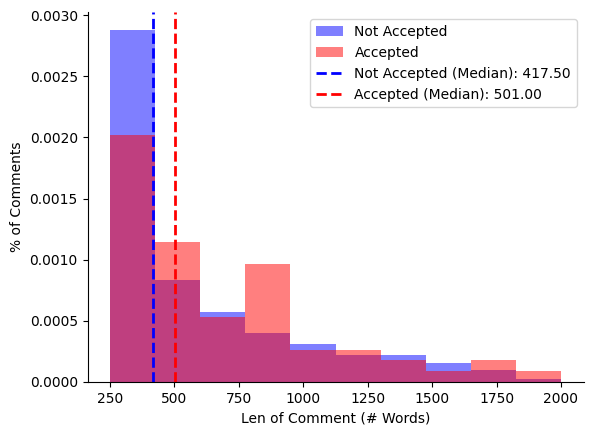

In [450]:
import matplotlib.pyplot as plt

neg_str_lens = negative_matches['actual_comment'].str.split().str.len().loc[lambda s: (s > 250) & (s < 2_000)]
neg_median = neg_str_lens.median()

pos_str_lens = positive_matches['actual_comment'].str.split().str.len().loc[lambda s: (s > 250) & (s < 2_000)]
pos_median = pos_str_lens.median()

ax = neg_str_lens.hist(range=(250, 2_000), density=True, label='Not Accepted', alpha=.5, bins=10, color='b')
ax = pos_str_lens.hist(range=(250, 2_000), density=True, label='Accepted', ax=ax, alpha=.5, bins=10, color='r')
plt.axvline(neg_median, color='blue', linestyle='dashed', linewidth=2, label=f'Not Accepted (Median): {neg_median:.2f}')
plt.axvline(pos_median, color='red', linestyle='dashed', linewidth=2, label=f'Accepted (Median): {pos_median:.2f}')

ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
ax.set_ylabel('% of Comments')
ax.set_xlabel('Len of Comment (# Words)')
plt.legend()

In [43]:
negative_matches = (
    comments_df
         .loc[lambda df: df['Docket ID'].isin(positive_matches['index'])]
         .rename(columns={'Docket ID': 'index', 'text': 'actual_comment'})
         [['index', 'actual_comment']]
         .loc[lambda df: df['actual_comment'].str.split().str.len() > 100]
         .loc[lambda df: ~df['actual_comment'].isin(positive_matches['actual_comment'])]
)

In [44]:
TASK_PROMPT = """You are a helpful legal assistant. 
I will show you a proposed rule. Write an initial call for us to put out seeking public comment, in 1-2 sentences. 
Please express your summary to be read by a member of the public and tell the public that feedback is being requested.
(Please request feedback.)

<call>
{input_text}
</call>

Your response:
"""

In [45]:
for_calls = (
    summary_df
         .loc[lambda df: df['docket_id'].isin(positive_matches['index'])]
         .loc[lambda df: df['csv_name'].isin(['notice', 'rule', 'proposed_rules'])]
         [['docket_id', 'processed_text']]
)

NameError: name 'summary_df' is not defined

In [46]:
calls = await p.process_batch( for_calls['processed_text'].tolist(), prompt_template=TASK_PROMPT)

NameError: name 'for_calls' is not defined

In [185]:
for_calls['call'] = calls

In [187]:
for_calls.head(2)

,docket_id,processed_text,call
767,EPA-HQ-OAR-2015-0072,"\n \n Federal Register, Volume 85 Issue 20 (Th...",The EPA has released a Policy Assessment summa...
773,EPA-HQ-OAR-2018-0276,"\n \n Federal Register, Volume 85 Issue 166 (W...",EPA is proposing greenhouse‑gas (CO2) emission...


In [190]:
(pd.concat([
    positive_matches,
    negative_matches
])
 .merge(for_calls[['docket_id', 'call']], how='left', left_on='index', right_on='docket_id')
 .to_csv('full_matched_comment_df__epa.csv')
)

In [85]:
matched_comments_df

,responses_to_comments,comment_text,matched_pairs
EPA-HQ-OA-2020-0128,[1. Q: Are any of the compliance deadlines for...,[I am strongly opposed to the proposed rule. I...,[(Comment: Many commenters stated general supp...
EPA-HQ-OAR-2001-0001,"[In general, comments made by both the electri...","[See attached\n, See attached\n, See attached\...",[]
EPA-HQ-OAR-2002-0011,[One commenter was concerned that because the ...,"[See attached\n, See attached\n, See attached\...",[]
EPA-HQ-OAR-2002-0022,[They claimed that the Federal enforceability ...,"[See attached\n, See attached\n, See attached\...",[]
EPA-HQ-OAR-2002-0024,[A number of commenters recommended that wo se...,"[See attached\n, See attached\n, See attached\...",[]
...,...,...,...
EPA-R09-OAR-2020-0309,[The comments in the letter are generally supp...,[The consequences for not meeting the Environm...,[]
EPA-R10-OAR-2018-0824,[Comment 1: Commenters asserted that the EPA's...,[The attached comments are being submitted on ...,[(Comment 1: Commenters asserted that the EPA'...
EPA-R10-OAR-2019-0412,[Two comments were supportive of the actions a...,[I invented and patented a novel wood stove at...,[]
EPA-R10-OAR-2019-0640,"[We received one comment, submitted anonymousl...",[The EPA would like to make revisions to the O...,[]


In [86]:
finalized_matched_comments_df

,response,comment


# Read in full content files

In [139]:
comments_df['Attachment Files'].dropna().iloc[0]

'https://downloads.regulations.gov/DOE-HQ-2016-0024-0002/attachment_1.pdf'

In [124]:
content_files = glob.glob('../data/bulk_downloads/*/*')
content_files = list(filter(lambda x: 'public_submission.csv' not in x, content_files))
content_files = list(filter(lambda x: '.csv' in x, content_files))

In [127]:
content_files = list(map(lambda x: pd.read_csv(x, on_bad_lines='skip'), content_files))

/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_12578/867627012.py:1: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  content_files = list(map(lambda x: pd.read_csv(x, on_bad_lines='skip'), content_files))


In [131]:
full_content_df = pd.concat(content_files)

In [134]:
full_content_df['Attachment Files'].dropna().iloc[0]

'https://downloads.regulations.gov/DOE-OHA-2023-0044-0006/attachment_1.pdf'

In [143]:
full_content_df.iloc[0].to_dict()

{'Document ID': 'DOE_FRDOC_0001-4659',
 'Agency ID': 'DOE',
 'Docket ID': 'DOE_FRDOC_0001',
 'Tracking Number': nan,
 'Document Type': 'Notice',
 'Posted Date': '2023-05-08T04:00Z',
 'Is Withdrawn?': False,
 'Federal Register Number': '2023-09745',
 'FR Citation': nan,
 'Title': 'Application for Renewal of Authorization to Export Electric Energy: Matador Power Marketing, Inc.',
 'Comment Start Date': '2023-05-08T04:00Z',
 'Comment Due Date': '2023-06-08T03:59:59Z',
 'Allow Late Comments': False,
 'Comment on Document ID': nan,
 'Effective Date': nan,
 'Implementation Date': nan,
 'Postmark Date': nan,
 'Received Date': '2023-05-08T04:00Z',
 'Author Date': nan,
 'Related RIN(s)': nan,
 'Authors': nan,
 'CFR': nan,
 'Abstract': nan,
 'Legacy ID': nan,
 'Media': nan,
 'Document Subtype': nan,
 'Exhibit Location': nan,
 'Exhibit Type': nan,
 'Additional Field 1': nan,
 'Additional Field 2': nan,
 'Topics': nan,
 'Duplicate Comments': nan,
 'OMB/PRA Approval Number': nan,
 'Page Count': nan

# Inspect

In [35]:
submission_fn = '../data/bulk_downloads/epa_2020_2021/public_submission.csv'
comments = pd.read_csv(submission_fn)

/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_77096/1451896436.py:2: DtypeWarning: Columns (54,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  comments = pd.read_csv(submission_fn)
